In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def masked_rmse(y_pred, y_true):
    with np.errstate(divide="ignore", invalid="ignore"):
        mask = np.not_equal(y_true, 0)
        mask = mask.astype(np.float32)
        mask /= np.mean(mask)
        rmse = np.square(np.abs(y_pred - y_true))
        rmse = np.nan_to_num(rmse * mask)
        rmse = np.sqrt(np.mean(rmse))
        return rmse

def masked_mae(y_pred, y_true):
    with np.errstate(divide="ignore", invalid="ignore"):
        mask = np.not_equal(y_true, 0)
        mask = mask.astype(np.float32)
        mask /= np.mean(mask)
        mae = np.abs(y_pred - y_true)
        mae = np.nan_to_num(mae * mask)
        mae = np.mean(mae)
        return mae

def masked_mape(y_pred, y_true, null_val=0):
    with np.errstate(divide="ignore", invalid="ignore"):
        if np.isnan(null_val):
            mask = ~np.isnan(y_true)
        else:
            mask = np.not_equal(y_true, null_val)
        mask = mask.astype("float32")
        mask /= np.mean(mask)
        mape = np.abs(np.divide((y_pred - y_true).astype("float32"), y_true))
        mape = np.nan_to_num(mask * mape)
        return np.mean(mape)

In [3]:
def masked_mae_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()

def masked_mape_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(torch.div(y_true - y_pred, y_true))
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()

def masked_rmse_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.pow(y_true - y_pred, 2)
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return torch.sqrt(loss.mean())

In [4]:
df_plus = pd.read_csv('../METRLA/metr-la.csv.gz')
df_plus

,timestamp,sensorid,speed,weekdaytime,speed_y
0,2012-03-01 00:00:00,773869,64.375000,0.428784,63.132937
1,2012-03-01 00:00:00,767541,67.625000,0.428784,64.867063
2,2012-03-01 00:00:00,767542,67.125000,0.428784,66.170635
3,2012-03-01 00:00:00,717447,61.500000,0.428784,61.943452
4,2012-03-01 00:00:00,717446,66.875000,0.428784,65.241071
...,...,...,...,...,...
7094299,2012-06-27 23:55:00,717592,66.444444,0.428288,62.377595
7094300,2012-06-27 23:55:00,717595,68.444444,0.428288,66.349054
7094301,2012-06-27 23:55:00,772168,63.555556,0.428288,64.207723
7094302,2012-06-27 23:55:00,718141,68.666667,0.428288,66.785409


In [5]:
def get_history_average(data):
    num_nodes = 207
    num_samples = data.shape[0] // num_nodes
    
    preds, labels = [], []
    data_speed = data['speed'].values.reshape(-1, num_nodes, 1)  # correct!!!!
    data_speedy = data['speed_y'].values.reshape(-1, num_nodes, 1) # correct!!!!
    print(data_speed.shape, data_speedy.shape)
    
    num_test = round(num_samples * 0.2)  # 6854
    print('num_test', num_test)
    preds, labels = data_speedy[-num_test:], data_speed[-num_test:]
    test_preds, test_labels = torch.from_numpy(preds), torch.from_numpy(labels)
    rmse = masked_rmse_loss(test_preds, test_labels)
    mape = masked_mape_loss(test_preds, test_labels)
    mae = masked_mae_loss(test_preds, test_labels)
    print('Historical Average ---- Our method')
    print('\t'.join(['Model', 'Horizon', 'MAE', 'RMSE', 'MAPE']))
    for horizon in [1, 3, 6, 12]:
        line = 'HA\t%d\t%.2f\t%.2f\t%.2f' % (horizon, mae, rmse, mape * 100)
        print(line)
        
get_history_average(df_plus)

(34272, 207, 1) (34272, 207, 1)
num_test 6854
Historical Average ---- Our method
Model	Horizon	MAE	RMSE	MAPE
HA	1	4.15	7.77	12.90
HA	3	4.15	7.77	12.90
HA	6	4.15	7.77	12.90
HA	12	4.15	7.77	12.90


In [6]:
y_pred, y_true = df_plus['speed_y'].values.reshape(-1, 207), df_plus['speed'].values.reshape(-1, 207)
y_pred, y_true = y_pred[-6854:,], y_true[-6854:,]
print(y_pred.shape, y_true.shape)
normal_inds = (np.abs(y_pred-y_true) < 10.0)
abnormal_inds = (np.abs(y_pred-y_true) > 10.0)
y_true_normal, y_true_abnormal = y_true[normal_inds], y_true[abnormal_inds]
y_pred_normal, y_pred_abnormal = y_pred[normal_inds], y_pred[abnormal_inds]
print(y_true_normal.shape, y_true_abnormal.shape)
print(y_pred_normal.shape, y_pred_abnormal.shape)

(6854, 207) (6854, 207)
(1118799,) (299976,)
(1118799,) (299976,)


(array([171831.,   1186.,   3975.,   6130.,   7703.,   8950.,   9619.,
          9299.,   8700.,   7598.,   6325.,   5492.,   5146.,   4724.,
          4558.,   4371.,   5594.,   9142.,  12192.,   7441.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ,
        38.5, 42. , 45.5, 49. , 52.5, 56. , 59.5, 63. , 66.5, 70. ]),
 <BarContainer object of 20 artists>)

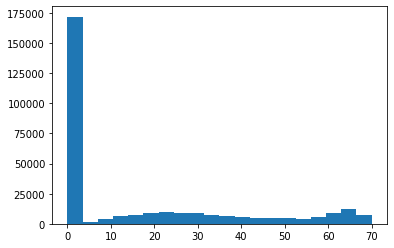

In [7]:
plt.hist(y_true_abnormal, bins=20)

(array([  276.,  1666.,  4693.,  6277.,  8015.,  8853.,  9539.,  9213.,
         8255.,  7426.,  6181.,  5349.,  4982.,  4723.,  4357.,  4416.,
         5645.,  9162., 12041.,  7194.]),
 array([ 0.88888889,  4.34444444,  7.8       , 11.25555556, 14.71111111,
        18.16666667, 21.62222222, 25.07777778, 28.53333333, 31.98888889,
        35.44444444, 38.9       , 42.35555556, 45.81111111, 49.26666667,
        52.72222222, 56.17777778, 59.63333333, 63.08888889, 66.54444444,
        70.        ]),
 <BarContainer object of 20 artists>)

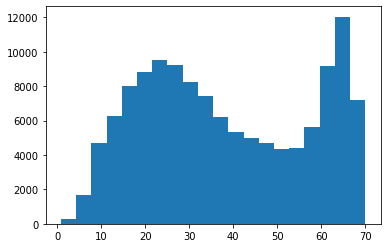

In [8]:
y_true_abnormal_nozero = y_true_abnormal[y_true_abnormal!=0] # 出去0值看一下分布
plt.hist(y_true_abnormal_nozero, bins=20)

(array([   57.,    69.,   202.,   649.,  1516.,  3053.,  4690.,  6180.,
         8581., 10842., 12254., 13856., 15999., 17741., 20183., 21900.,
        28602., 42886., 54645., 36071.]),
 array([ 4.87847222,  8.13454861, 11.390625  , 14.64670139, 17.90277778,
        21.15885417, 24.41493056, 27.67100694, 30.92708333, 34.18315972,
        37.43923611, 40.6953125 , 43.95138889, 47.20746528, 50.46354167,
        53.71961806, 56.97569444, 60.23177083, 63.48784722, 66.74392361,
        70.        ]),
 <BarContainer object of 20 artists>)

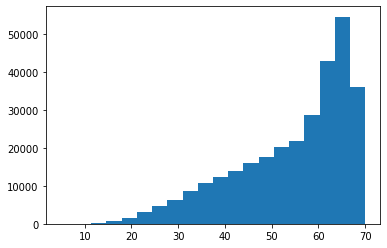

In [9]:
plt.hist(y_pred_abnormal, bins=20)

(array([7.30000e+01, 4.35000e+02, 1.76600e+03, 3.13800e+03, 5.28800e+03,
        8.31500e+03, 9.27300e+03, 1.06240e+04, 1.30440e+04, 1.34440e+04,
        1.20910e+04, 1.01750e+04, 1.55850e+04, 1.84910e+04, 2.93280e+04,
        5.59730e+04, 1.12676e+05, 1.99853e+05, 3.07569e+05, 2.91658e+05]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ,
        38.5, 42. , 45.5, 49. , 52.5, 56. , 59.5, 63. , 66.5, 70. ]),
 <BarContainer object of 20 artists>)

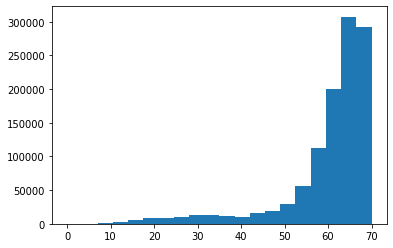

In [10]:
plt.hist(y_true_normal, bins=20)

(array([2.82000e+02, 1.00700e+03, 1.64000e+03, 3.51300e+03, 5.67000e+03,
        8.82200e+03, 9.92600e+03, 1.21920e+04, 1.34850e+04, 1.34670e+04,
        1.12700e+04, 1.14240e+04, 1.67420e+04, 2.35470e+04, 3.88950e+04,
        7.18020e+04, 1.41542e+05, 2.32496e+05, 3.07759e+05, 1.93318e+05]),
 array([ 4.86805556,  8.12465278, 11.38125   , 14.63784722, 17.89444444,
        21.15104167, 24.40763889, 27.66423611, 30.92083333, 34.17743056,
        37.43402778, 40.690625  , 43.94722222, 47.20381944, 50.46041667,
        53.71701389, 56.97361111, 60.23020833, 63.48680556, 66.74340278,
        70.        ]),
 <BarContainer object of 20 artists>)

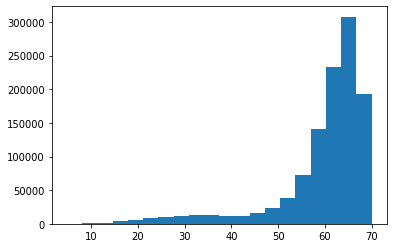

In [11]:
plt.hist(y_pred_normal, bins=20)

In [12]:
def calculate_normal_abnormal(data, mode, threshold):
    y_pred, y_true = data['speed_y'].values.reshape(-1, 207), data['speed'].values.reshape(-1, 207)
    y_pred, y_true = y_pred[-6854:,], y_true[-6854:,]
    n_total = y_true.shape[0] * y_true.shape[1]
    print(y_pred.shape, y_true.shape, n_total)
    if mode == 'normal':
        inds = (np.abs(y_pred-y_true) <= threshold)
    else:
        inds = (np.abs(y_pred-y_true) > threshold)
    y_pred, y_true = y_pred[inds], y_true[inds]
    print(y_pred.shape, y_true.shape, y_true.shape[0]/n_total * 100)
    
    mae = masked_mae(y_pred, y_true)
    mape = masked_mape(y_pred, y_true)
    rmse = masked_rmse(y_pred, y_true)
    print('Historical Average with Threshold', threshold)
    print('Horizon overall: mae: {:.4f}, mape: {:.4f}, rmse: {:.4f}'.format(mae, mape, rmse))

    test_preds, test_labels = torch.from_numpy(y_pred), torch.from_numpy(y_true)
    rmse = masked_rmse_loss(test_preds, test_labels)
    mape = masked_mape_loss(test_preds, test_labels)
    mae = masked_mae_loss(test_preds, test_labels)
    print('Historical Average ---- Our method --- Torch Loss')
    print('\t'.join(['Model', 'Horizon', 'MAE', 'RMSE', 'MAPE']))
    for horizon in [1, 3, 6, 12]:
        line = 'HA\t%d\t%.2f\t%.2f\t%.2f' % (horizon, mae, rmse, mape * 100)
        print(line)

In [13]:
calculate_normal_abnormal(df_plus, 'normal', 10.0)

(6854, 207) (6854, 207) 1418778
(1118802,) (1118802,) 78.85673445739926
Historical Average with Threshold 10.0
Horizon overall: mae: 2.3099, mape: 0.0465, rmse: 3.2019
Historical Average ---- Our method --- Torch Loss
Model	Horizon	MAE	RMSE	MAPE
HA	1	2.31	3.20	4.65
HA	3	2.31	3.20	4.65
HA	6	2.31	3.20	4.65
HA	12	2.31	3.20	4.65


In [14]:
calculate_normal_abnormal(df_plus, 'abnormal', 10.0)

(6854, 207) (6854, 207) 1418778
(299976,) (299976,) 21.143265542600744
Historical Average with Threshold 10.0
Horizon overall: mae: 20.1575, mape: 0.8491, rmse: 22.3155
Historical Average ---- Our method --- Torch Loss
Model	Horizon	MAE	RMSE	MAPE
HA	1	20.16	22.32	84.91
HA	3	20.16	22.32	84.91
HA	6	20.16	22.32	84.91
HA	12	20.16	22.32	84.91
